In [76]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import time

In [77]:
# set Chinese font
font = {'family': 'MicroSoft YaHei',
        'weight': 'bold',
        'size': '10'}
matplotlib.rc("font", **font)

In [78]:
# Helper function - Used to display images
def imshow(img,title=None):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [79]:
# Set the hyperparameters and constants

learning_rate = 0.0005      # learning rate
batch_size = 100           # batch size
epochs_num = 16            # epoch number
download = True            # data set loading method
use_gpu = 0                # CUDA GPU accelerate  1: TRUE  0: FALSE
is_train = 1               # use model 1: retrain 0: load existing model
show_pic = 1               # show picture  1: show  0: ingore

In [80]:
# load MNIST dataset
train_dataset = datasets.MNIST(root='.',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=download)


In [81]:
train_loader = DataLoader(dataset=train_dataset,  # load training data
                          shuffle=True,           # shuffle data
                          batch_size=batch_size)  # set batch size = 100

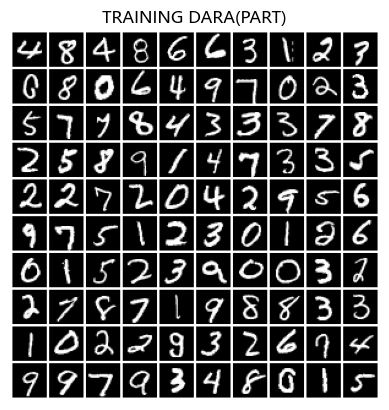

In [82]:
# Store in an iterator and display some data
dataiter = iter(train_loader)
batch = next(dataiter)
if show_pic:
    imshow(make_grid(batch[0],nrow = 10,padding = 2,pad_value = 1),'TRAINING DARA(PART)')


In [83]:
# initialize neural network
class MNIST_Network(nn.Module):
    def __init__(self):
        super(MNIST_Network, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding = 2) # convolutional layer
        self.relu1 = nn.ReLU()                                      # activation 
        self.pool1 = nn.MaxPool2d(2, stride=2)                      # maximum pooling layer

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)

        self.fc3 = nn.Linear(7*7*64, 1024)                       # fully connected layer
        self.relu3 = nn.ReLU()                                   # activation

        self.fc4 = nn.Linear(1024, 10)                           # fully connected 
        self.softmax4 = nn.Softmax(dim=1)                        # softmax layer

    # forward
    def forward(self, input1):
        x = self.conv1(input1)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size()[0], -1)
        x = self.fc3(x)
        x = self.relu3(x)

        x = self.fc4(x)
        x = self.softmax4(x)
        return x


In [84]:
# initialize network
net = MNIST_Network()

epoch 0: loss 1.5123264789581299
epoch 1: loss 1.476741909980774
epoch 2: loss 1.471484661102295
epoch 3: loss 1.4728362560272217
epoch 4: loss 1.4631242752075195
epoch 5: loss 1.4762600660324097
epoch 6: loss 1.4661686420440674
epoch 7: loss 1.461676001548767
epoch 8: loss 1.4712001085281372
epoch 9: loss 1.4808207750320435
epoch 10: loss 1.4613287448883057
epoch 11: loss 1.4714360237121582
epoch 12: loss 1.4624980688095093
epoch 13: loss 1.4612103700637817
epoch 14: loss 1.4617431163787842
epoch 15: loss 1.4730753898620605


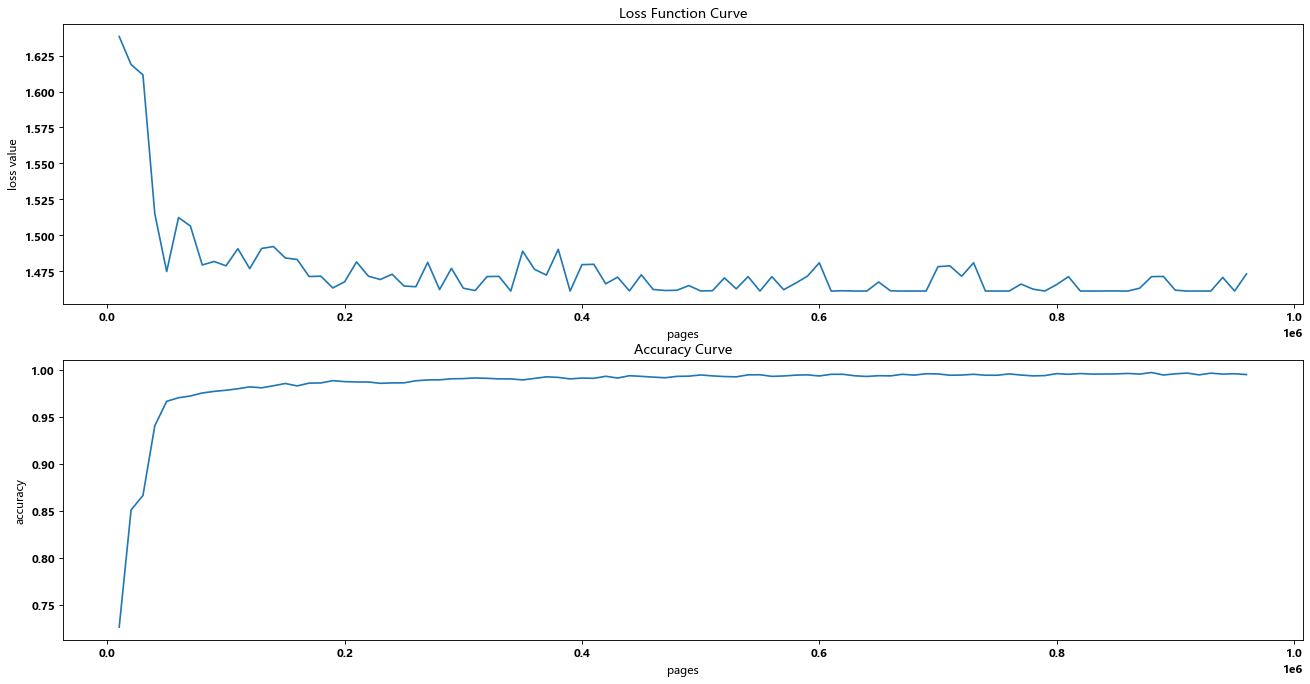

In [85]:
if is_train:
    criterion = nn.CrossEntropyLoss()  # cross entropy loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # using adam 

    counter = []
    loss_history = []
    correct_history = []
    epoch_number = 0
    correct_cnt = 0
    counter_temp = 0
    record_interval = 100
    # Multiple iteration training network
    for epoch in range(0, epochs_num):
        for i, data in enumerate(train_loader, 0):
            img, label = data
            if use_gpu:  
                img, label = img.cuda(), label.cuda()

            optimizer.zero_grad()            # clear network status
            output = net(img)                # forward
            loss = criterion(output, label)  # calculate loss function
            loss.backward()                  # back propagation
            optimizer.step()                 # update parameters

            _, predict = torch.max(output, 1)
            correct_cnt += (predict == label).sum()  # compare actual value and predicted value

            # Store loss values and accuracy
            if i%record_interval == record_interval-1:
                counter_temp += record_interval * batch_size
                counter.append(counter_temp)
                loss_history.append(loss.item())
                correct_history.append(correct_cnt.float().item()/(record_interval*batch_size))
                correct_cnt = 0
        print("epoch {}: loss {}".format(epoch, loss.item()))

    # Plot loss function and precision curve
    if show_pic:
        plt.figure(figsize=(20, 10), dpi=80)
        plt.subplot(211)
        plt.plot(counter, loss_history)
        plt.xlabel('pages')
        plt.ylabel('loss value')
        plt.title('Loss Function Curve')
        plt.subplot(212)
        plt.plot(counter, correct_history)
        plt.xlabel('pages')
        plt.ylabel('accuracy')
        plt.title('Accuracy Curve')
        plt.show()

    # Storage model parameter
    state = {'net':net.state_dict()}
    torch.save(net.state_dict(),'.\modelpara.pth')

In [86]:
# Load model parameter
if use_gpu:
    net.load_state_dict(torch.load('.\modelpara.pth'))
else:
    net.load_state_dict(torch.load('.\modelpara.pth', map_location='cpu'))


In [87]:
test_dataset = datasets.MNIST(root='.',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=download)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          shuffle=True,
                                          batch_size=batch_size)

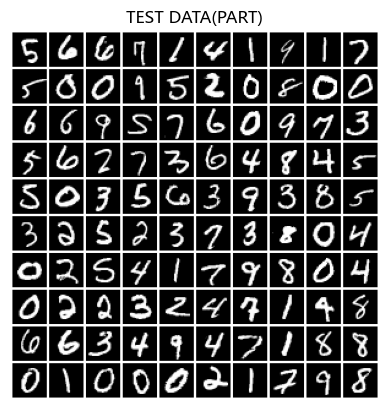

In [88]:
# Store model parameters into iterators to display partial data
dataiter = iter(test_loader)
batch = next(dataiter)
if show_pic:
    imshow(torchvision.utils.make_grid(batch[0],nrow=10,padding=2,pad_value=1),'TEST DATA(PART)')


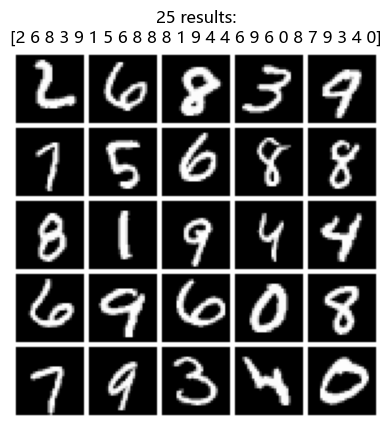

In [89]:
# Training set predictive testing
start = time.time()
correct = 0
for i,data in enumerate(test_loader, 0):
    img,label = data
    if use_gpu:             
        img, label = img.cuda(), label.cuda()
    output = net(img)       
    _,predict = torch.max(output,1)
    correct += (predict==label).sum()  
end = time.time()
# show part of the result
if show_pic:
    imshow(torchvision.utils.make_grid(img[75:100].cpu(),nrow=5,padding=2,pad_value=1),'25 results:\n'+str(predict[75:100].cpu().numpy()))


In [90]:
# print accuracy and cost
print('MNIST accuracy rate: {:.2f}'.format(correct.cpu().numpy()/len(test_dataset)*100)+'%')
print ('10000 pages cost: {:.3f}'.format(end-start)+' s')


MNIST accuracy rate: 99.11%
10000 pages cost: 3.056 s
